In [187]:
# import libraries  
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import sys
import seaborn as sns
import scipy as sp
%matplotlib inline

# import pre-processing modules 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel 

# import classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# import evaluation modules
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

In [188]:
df_original = pd.read_csv(r"C:/Users/Yehonatan/PycharmProject/DS/projects/la_liga_project/to ignore/la_liga_data.csv")
#df_original.info()

In [189]:
# define the custom functions that will be used on the project  

def deal_nans(df, percantage_nan):
    nans = df[df.columns[df.isnull().any()]]
    nan_col_names = list(nans)
    for i in nan_col_names:
        count_nan = df[i].isnull().sum()
        if count_nan/len(df[i]) >= 0.1:       # if nans are more than 10% delete the column 
            df = df.drop(columns=[i])
        else:
            col_avg = df[i].mean()
            df[i] = df[i].fillna(col_avg)
    return df 


# this function calcs the p-values and determines wether H_0 null hypothesis is rejected or accepted

def pvalue_filter(target, features, alpha): # returns a list of columns that are possible drop, p_val > alpha, corr, pval
    features_columns_names = list(features)
    target_column_name = list(target)
    features_np = features.to_numpy()
    target_np = target.to_numpy()
    drop_index = []
    p_val_list =[]
    corr_list = []
    
    for i in range(len(features_columns_names)):
        corr, p_val = sp.stats.pearsonr(features_np[:,i], target_np)
        corr_list.append(round(corr,3))
        if p_val > alpha:           # accept the null hypothesis, no statisitcal significance  
            drop_index.append(i)
            p_val_list.append(p_val)
            
    drop_col = [features_columns_names[i] for i in drop_index]
    return drop_col, corr_list, p_val_list

# cthis function returns the selected and rejected columns (features) after correlation check between the features 
def features_corr_filter(features, corr_cutoff): 
    corr = features.corr()
    columns = np.full((corr.shape[0],), True, dtype=bool) # create boolean filter 

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= corr_cutoff:
                columns[j] = False

    rejected_columns = x_train.columns[np.invert(columns)]
    #print('reject',rejected_columns)
    selected_columns = x_train.columns[columns]
    #print('selected',selected_columns)
    return selected_columns, rejected_columns

def correlation_heatmap(df):
    
    correlations = df.corr()
    fig, ax = plt.subplots(figsize=(8,8))
    colormap = sns.color_palette("Reds", as_cmap=True)
    sns.heatmap(correlations, cmap=colormap,fmt='.2f',
                square=True, linewidths=.5, annot=True)
    
    plt.show()


In [190]:
###### EDA and data processing ############### 

df = df_original.copy()
# deal with object type attributes 
col_list = df.select_dtypes(include=['object']).columns.to_list()
df = df.drop(columns = ['start_time', 'round', 'dayofweek', 'opponent']) #drop categorical columns that in my perspective dont contribute 
df['venue'] = df['venue'].apply(lambda x : 1 if x == 'Home' else 0) 

# for now I turn this classifier to be a WIN classifier 
df['result'] = df['result'].apply(lambda x : 1 if x == 'W' else 0) 

#turn df into float 64 
df=df.astype('float64')

# deal with NAN values 
# specific columns to deal with

df['gk_save_pct'] = df['gk_save_pct'].fillna(100) # no shots on target means no saves in a way same effect as 100% saves
df = df.replace({'gk_save_pct': { -100 : 0}}) #replaced an outlier of -100 that should have been 0 
df['own_goals'] = df['own_goals'].fillna(0) # safe to assume that if there is a NAN there were no owngoals as it is a rare occasion 
df = df.drop(columns=['tackles_interceptions', 'Unnamed: 0']) # all Nan_s in this column

deal_nans(df, 0.1) # fill columns with more then 10% nans with the column's mean value 


#count_nan = df['tackles_interceptions'].isnull().sum()
#print('Number of NaN values present: ' + str(count_nan))

# divide to x,y sets 
y = df['result']
x = df.drop(['result'], axis=1)

# divide into test set and train set   
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)

train_set = pd.concat([x_train,y_train],axis=1) #for possible checks on test_set before feature selection





In [191]:
######### APPLY FEATURE SELECTION ##########

### STEP 1 ###
# drop the statisticly insignificant features 

drop_col, corr_list, p_val_list = pvalue_filter(y_train, x_train, 0.05)
#print(drop_col)
x_train = x_train.drop(drop_col, axis=1)
x_train.rename(columns = {'passes.1':'attempted_passes'}, inplace=True)




In [192]:
### STEP 2 ###
# drop features that might indicate on loss or win . for instance assists = goals and it is quite obvious that many assists 
# will most likely lead to win. I left features that on a first glance might not indicate a win
# drop features that are by product of different circumstances like xg related features
# leave features that are controllable - meaning can be worked and controlled by the team 

hand_pick_drop = ['gk_clean_sheets','gk_goals_against', 'goals_for','goals_against','gk_psxg_net', 'dribbles_vs','dribbles_completed',
                  'passes_received_pct', 'assists', 'throw_ins','passes_left_foot', 'passes_right_foot',
                  'sca_shots','passes_head','gca','gca_passes_live', 'gca_passes_dead', 'gca_dribbles','gca_shots', 'gca_fouled', 
                  'gca_defense','goals','goals_per_shot', 'goals_per_shot_on_target','xg', 'npxg', 'npxg_per_shot', 
                  'pens_made', 'pens_att','xg_net', 'npxg_net','own_goals']

x_train = x_train.drop(hand_pick_drop, axis=1)

In [193]:
### STEP 3 ###
### apply corr filter on x_train #### 

selected_columns, rejected_columns = features_corr_filter(x_train, 0.9)
x_train = x_train[selected_columns]
x_test = x_test[selected_columns]
#x_train.info()
train_set = pd.concat([y_train, x_train],axis=1)


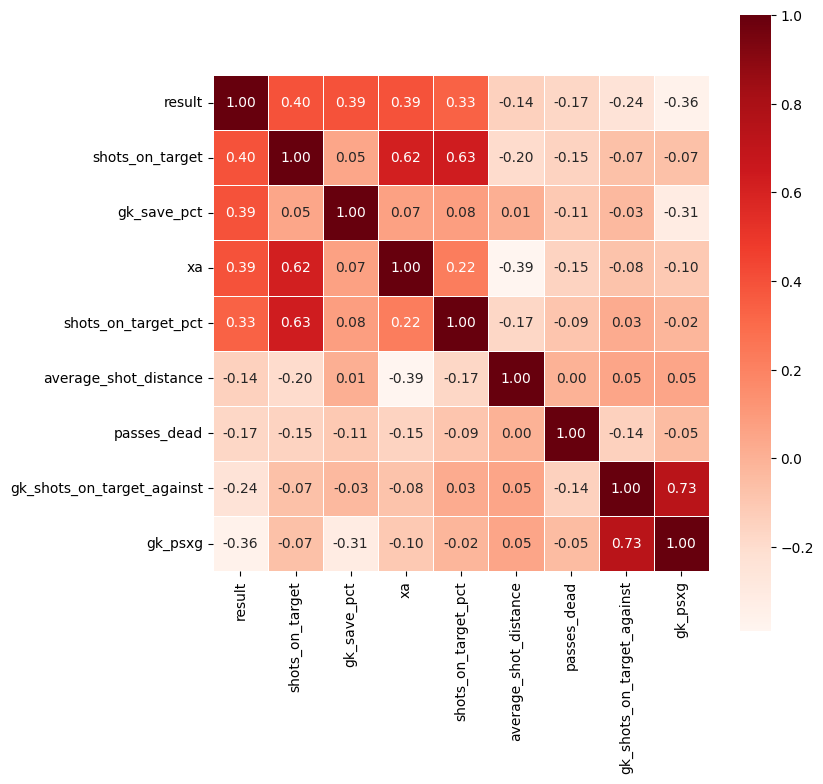

In [195]:
# plot heatmap of top 4 positive and negative correlations
train_set_corr = train_set.corr()
train_set_target = train_set_corr['result'].sort_values(ascending=False)
top_4_corr = pd.concat([train_set_target.iloc[0:5], train_set_target.iloc[-4:]]).index.tolist() # top 4 positive and negative correlations to target

corr_plot_df = train_set[top_4_corr]
correlation_heatmap(corr_plot_df)


In [196]:
#### after all feature selection filtering
### now x_train has 84 features (half compared to the beginning) #### pvalue drop has been made and high corr between features 

In [197]:
##### now we scale the data with standardscaler ##### prepre it for learning, convert to np array

scaler = StandardScaler()
x_train_np = x_train.to_numpy()   
x_train_np = scaler.fit_transform(x_train_np)

x_train_df = pd.DataFrame(x_train_np, columns= list(selected_columns)) # df after scaling
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
x_test_np = scaler.transform(x_test_np)

y_test_np =  y_test.to_numpy()

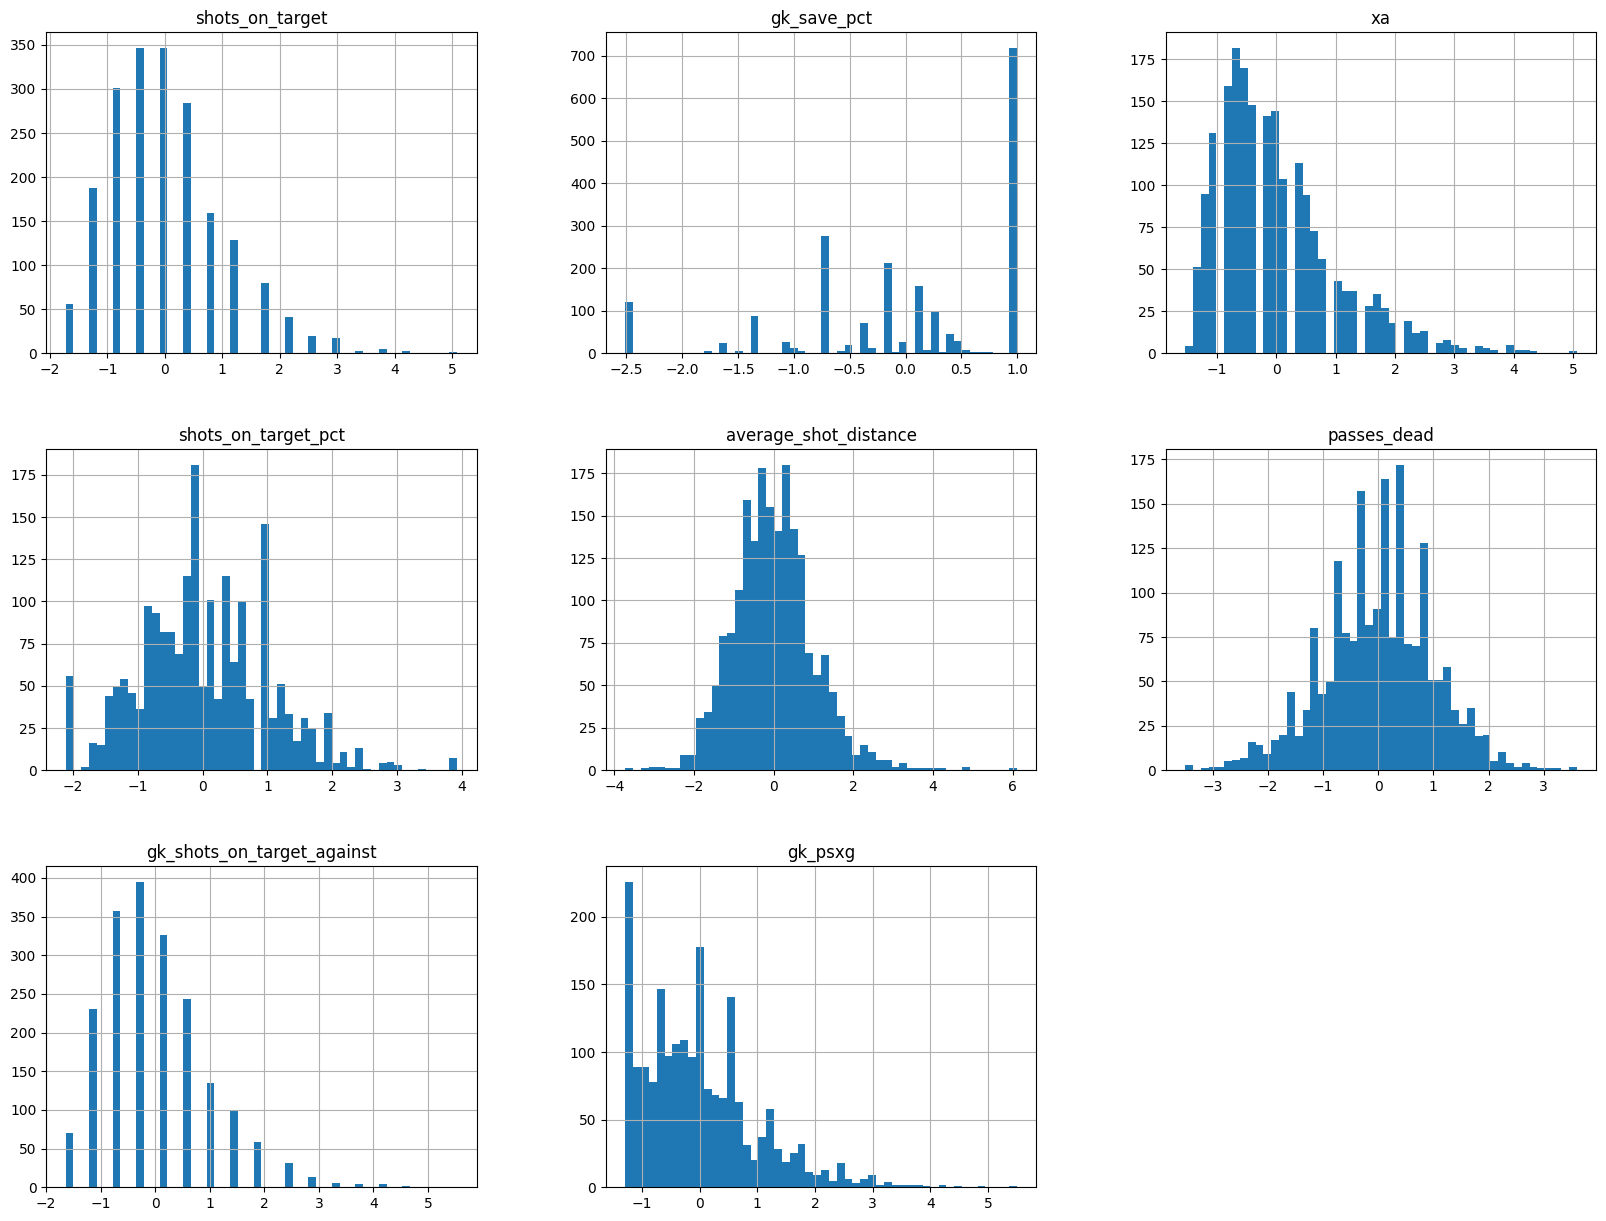

In [198]:
x_train_df[top_4_corr[1:]].hist(bins=50, figsize=(20,15))
plt.show()

In [103]:
#### apply classifiers ####

# tried three classifiers - ligostic reg gave slightly better rsults . yet it seems to not overfit as the others 
#and when I chose newton method the results were great


In [35]:
clf = RandomForestClassifier(n_estimators= 100, max_depth=2, random_state=9)
clf.fit(x_train_np, y_train_np)
y_train_pred = clf.predict(x_train_np)

In [493]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(x_train_np, y_train_np)
y_train_pred = clf.predict(x_train_np)

In [199]:
# newton method as lbfgs didnt converge and it gave the best outcome . could check other algos 
clf = LogisticRegression(random_state=9, max_iter=500, solver = 'newton-cg') 
clf.fit(x_train_np, y_train_np)
y_train_pred = clf.predict(x_train_np)

In [200]:
#### check the accuracy, precision and recall ###### all feature slection steps were applied

precision, recall, f_1, support = precision_recall_fscore_support(y_train_np, y_train_pred, average='binary')
accuracy = accuracy_score(y_train_np, y_train_pred)
print('accuracy :', np.round(accuracy,3))
print('precision :', np.round(precision,3))
print('recall :', np.round(recall,3))
print('f_score :', np.round(f_1,3))


accuracy : 0.849
precision : 0.823
recall : 0.817
f_score : 0.82


In [201]:
cv_3_accuracy = cross_val_score(clf, x_train , y_train, cv=3, scoring='accuracy')
#cv_3_precision = cross_val_score(clf, x_train , y_train, cv=3, scoring='precision')
#cv_3_recall = cross_val_score(clf, x_train , y_train, cv=3, scoring='recall')

print('cv_avg_accuracy :', np.round(cv_3_accuracy.mean(),3))
#print('cv_avg_precision', cv_3_precision.mean())
#print('cv_avg_recall', cv_3_recall.mean())

cv_avg_accuracy : 0.821


In [202]:
### Grid Search logistic reg ### 

params_l1 = {
    'penalty' : ['l1'],
    'solver' : ['liblinear', 'saga'],
    'max_iter' : [200,500,750,1000]
}

params_l2 = {
    'penalty' : ['l2'],
    'solver' : ['newton-cg', 'saga', 'sag' ],
    'max_iter' : [200,500,750,1000]
}

grid_search_l1 = GridSearchCV(estimator = clf, param_grid = params_l1, scoring = 'f1', cv = 3, verbose = 0)
grid_search_l2 = GridSearchCV(estimator = clf, param_grid = params_l2, scoring = 'f1', cv = 3, verbose = 0)

In [203]:
grid_search_l1.fit(x_train_np, y_train_np)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=500, random_state=9,
                                          solver='newton-cg'),
             param_grid={'max_iter': [200, 500, 750, 1000], 'penalty': ['l1'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1')

In [204]:
print('best parameters : ', grid_search_l1.best_params_)
print('best score for the parameters :', np.round(grid_search_l1.best_score_,3))

best parameters :  {'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
best score for the parameters : 0.788


In [205]:
grid_search_l2.fit(x_train_np, y_train_np)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=500, random_state=9,
                                          solver='newton-cg'),
             param_grid={'max_iter': [200, 500, 750, 1000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'saga', 'sag']},
             scoring='f1')

In [206]:
print('best parameters : ', grid_search_l2.best_params_)
print('best score for the parameters :', np.round(grid_search_l2.best_score_,3))

best parameters :  {'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
best score for the parameters : 0.782


In [113]:
#clf.get_params()

In [27]:
#print(classification_report(y_train_np, y_train_pred))  

In [207]:
### predict on TEST SET #####
y_test_pred = clf.predict(x_test_np)

In [208]:
### PREDICTION ASSESMENT ###
precision, recall, f_1, support = precision_recall_fscore_support(y_test_np, y_test_pred, average='binary')
accuracy = accuracy_score(y_test_np, y_test_pred)
print('accuracy :', np.round(accuracy,3))
print('precision :', np.round(precision,3))
print('recall :', np.round(recall,3))
print('f_score :', np.round(f_1,3))

accuracy : 0.826
precision : 0.813
recall : 0.767
f_score : 0.789


In [209]:
print(classification_report(y_test_np, y_test_pred))  

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       284
         1.0       0.81      0.77      0.79       210

    accuracy                           0.83       494
   macro avg       0.82      0.82      0.82       494
weighted avg       0.83      0.83      0.83       494



In [24]:
#x_train_df_scale.hist(bins=50, figsize=(20,15))
#plt.show()

In [186]:
#x_train['gk_save_pct'].hist(bins=50, figsize=(20,15))
#plt.show()

In [157]:
#x_train.nutmegs.value_counts() 
#x_train['gk_clean_sheets']

In [ ]:
#### general NOTES ###
# few attributes were removed at fbref so they exist in my data but I dont have the exact definition of them 